In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.signal import medfilt
from sklearn.metrics import accuracy_score

from code.parser.parse import Parser
import matplotlib.pyplot as plt
from code.wiener_kolmogorov.wiener_kolmogorov import WienerKolmogorov as WK
import seaborn as sns

sns.color_palette("hls", 8)

pre1 = Parser.read('../../runs/1/pre.txt')
abs1 = Parser.read('../../runs/1/abs.txt')
pre2 = Parser.read('../../runs/2/pre.txt')
abs2 = Parser.read('../../runs/2/abs.txt')

In [2]:
def calculate_critical_value(size, alpha):
    t_dist = stats.t.ppf(1 - alpha / (2 * size), size - 2)
    numerator = (size - 1) * np.sqrt(np.square(t_dist))
    denominator = np.sqrt(size) * np.sqrt(size - 2 + np.square(t_dist))
    critical_value = numerator / denominator
    print(f"Grubbs Critical Value: {critical_value}")
    return critical_value

def grubbs_stat(y):
    std_dev = np.std(y)
    avg_y = np.mean(y)
    abs_val_minus_avg = abs(y - avg_y)
    max_of_deviations = max(abs_val_minus_avg)
    max_ind = np.argmax(abs_val_minus_avg)
    Gcal = max_of_deviations / std_dev
    print(f"Grubbs Statistics Value: {Gcal}")
    return Gcal, max_ind

def check_G_values(Gs, Gc, inp, max_index):
    if Gs > Gc:
        print(f"{inp[max_index]}, {max_index} is an outlier")
    else:
        # print(f"{inp[max_index]} is not an outlier")
        pass

def ESD_test(input_series, alpha, max_outliers):
    for iteration in range(max_outliers):
        Gcritical = calculate_critical_value(len(input_series), alpha)
        Gstat, max_index = grubbs_stat(input_series)
        check_G_values(Gstat, Gcritical, input_series, max_index)
        input_series = np.delete(input_series, max_index)

def hampel(vals_orig):
    vals = vals_orig.copy()
    difference = np.abs(np.median(vals)-vals)
    median_abs_deviation = np.median(difference)
    threshold = 1.5 * median_abs_deviation
    outlier_idx = difference > threshold
    vals[outlier_idx] = 1
    for i in range(len(vals)):
        if vals[i] != 1:
            vals[i] = 0
    return(vals)

In [3]:
pre1 = pd.concat([pre1, abs1], ignore_index=True)
abs1 = pd.concat([abs1, abs1], ignore_index=True)
pre2 = pd.concat([pre2, abs2], ignore_index=True)
abs2 = pd.concat([abs2, abs2], ignore_index=True)

In [4]:
def filter_out(pres, abss):
    filters = []
    for abs in abss:
        filter = WK()
        filter.fit(abs["rssi"].to_numpy())
        filters.append(filter)
    outs = []
    print(filters)
    for i, pre in enumerate(pres):
        out = filters[i].transform(pre["rssi"].to_numpy())
        outs.append(out)
    return outs, filters

In [5]:
outs, filters = filter_out([pre1, pre2], [abs1, abs2])

[<code.wiener_kolmogorov.wiener_kolmogorov.WienerKolmogorov object at 0x7fc110dc21c0>, <code.wiener_kolmogorov.wiener_kolmogorov.WienerKolmogorov object at 0x7fc110df0400>]


In [8]:
ticks = list(range(0, 2 * 200 + 1, 2 * 25))

In [9]:
r1, r2 = medfilt(hampel(outs[0]), 15), medfilt(hampel(outs[1]), 77)

In [10]:
r2

array([0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [11]:
y = np.concatenate((np.ones(50), np.zeros(150)))

In [12]:
print(accuracy_score(y, r1))
print(accuracy_score(y, r2))

0.95
0.965


In [13]:
from sklearn.metrics import confusion_matrix

In [16]:
m1 = np.array(confusion_matrix(y, r1, labels=[0, 1]).ravel())
m2 = np.array(confusion_matrix(y, r2, labels=[0, 1]).ravel())
print((m1 + m2) * 0.5)

[145.    5.    3.5  46.5]


In [62]:
def subplot(pres, outs, titles):
    legend = ["RSSI в жилой комнате", "RSSI в офисе"]
    fig = plt.figure(figsize=(16, 12))
    n = len(pres)
    axs = []
    k = 1
    # for pre in pres:
    #     for out in outs:
    #         axs.append(fig.add_subplot(n, n, k))
    #         k += 1
    # for pre, out in pres, outs:
    for i, (pre, out) in enumerate(zip(pres, outs)):
        axs.append(fig.add_subplot(n, 1, k))
        axs[k - 1].plot(pre.rssi.to_numpy(), label=legend[0], linestyle="solid")
        axs[k-1].set_xticks(ticks)
        axs[k-1].set_xlabel("Время, с")
        axs[k-1].set_ylabel("RSSI, dBm")
        axs[k - 1].plot(out, label=legend[1], linestyle="dashed")
        # axs[k - 1].legend()
        axs[k - 1].set(title=titles[k-1])
        k += 1
        # axs.append(fig.add_subplot(n, 2, k))
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc = 'lower center')
    return fig

In [6]:
fig = subplot([pre1, pre2], outs, titles=["Замеры RSSI в жилой комнате", "Замеры RSSI в офисе"])
fig.show()
fig.savefig("shibaev_1.png")

NameError: name 'subplot' is not defined

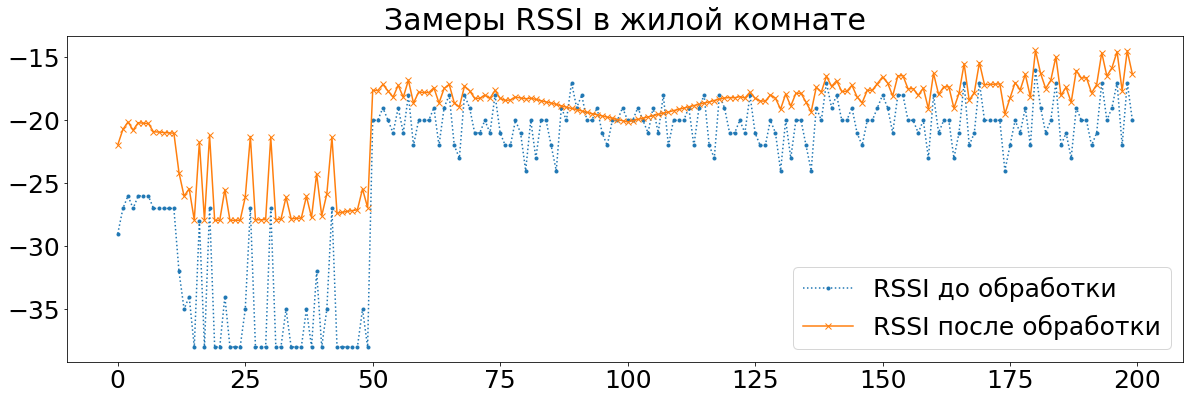

In [7]:
# axs.append(fig.add_subplot(n, 1, k))
#         axs[k - 1].plot(pre.rssi.to_numpy(), label=legend[0], linestyle="solid")
#         axs[k-1].set_xticks(ticks)
#         axs[k-1].set_xlabel("Время, с")
#         axs[k-1].set_ylabel("RSSI, dBm")
#         axs[k - 1].plot(out, label=legend[1], linestyle="dashed")
#         # axs[k - 1].legend()
#         axs[k - 1].set(title=titles[k-1])

plt.rcParams.update({'font.size': 25})
plt.figure(figsize=(20, 6))
# plt.rcParams.update({'text.color': "white"})
plt.plot(pre1.rssi.to_numpy(), label="RSSI до обработки", linestyle=":", marker=".")
plt.plot(outs[0], label="RSSI после обработки", linestyle="-", marker="x")
plt.title("Замеры RSSI в жилой комнате")
plt.legend(loc="lower right")
plt.savefig("shibaev_1.png")

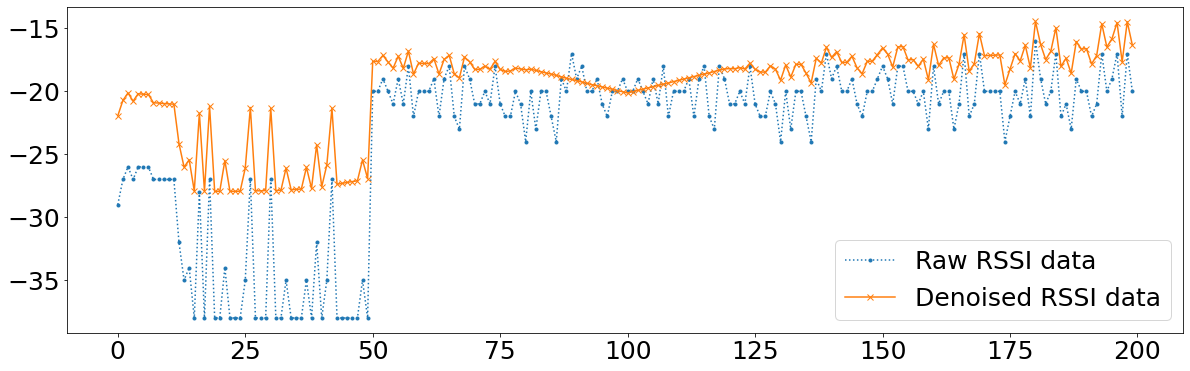

In [8]:
plt.rcParams.update({'font.size': 25})
plt.figure(figsize=(20, 6))
# plt.rcParams.update({'text.color': "white"})
plt.plot(pre1.rssi.to_numpy(), label="Raw RSSI data", linestyle=":", marker=".")
plt.plot(outs[0], label="Denoised RSSI data", linestyle="-", marker="x")
# plt.title("Замеры RSSI в жилой комнате")
plt.legend(loc="lower right")
plt.savefig("shibaev_1_eng.png")

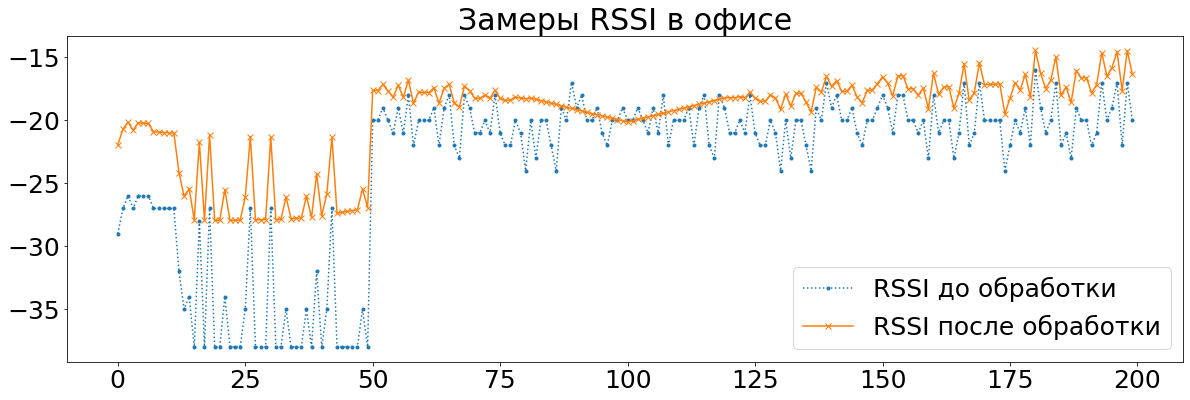

In [10]:
plt.rcParams.update({'font.size': 25})
plt.figure(figsize=(20, 6))
plt.plot(pre1.rssi.to_numpy(), label="RSSI до обработки", linestyle=":", marker=".")
plt.plot(outs[0], label="RSSI после обработки", linestyle="-", marker="x")
plt.title("Замеры RSSI в офисе")
plt.legend(loc="lower right")
plt.savefig("shibaev_2.png")

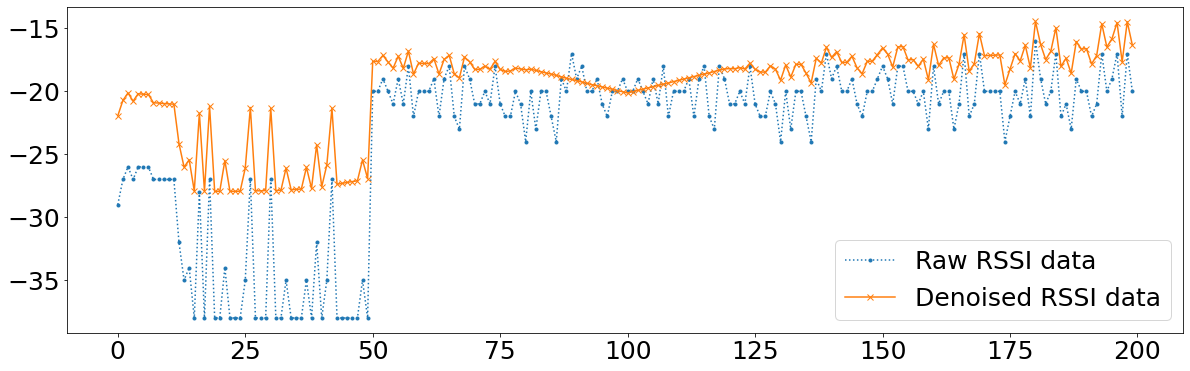

In [9]:
plt.rcParams.update({'font.size': 25})
plt.figure(figsize=(20, 6))
plt.plot(pre1.rssi.to_numpy(), label="Raw RSSI data", linestyle=":", marker=".")
plt.plot(outs[0], label="Denoised RSSI data", linestyle="-", marker="x")
plt.legend(loc="lower right")
plt.savefig("shibaev_2_eng.png")